# RoBert part 2
I hated, hated, hated, hated, hated that model <https://www.rogerebert.com/reviews/north-1994>.
  <p>

In [1]:
import os
import numpy as np
import pandas as pd
import glob
from pickleshare import PickleShareDB
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.backend import clear_session

In [2]:
# setup - typically keras shuffles data (randomly) and layers are randomly
# initialized. Here is some code to fix that. 
# Source: https://keras.io/getting_started/faq/
import random as python_random

!PYTHONHASHSEED=0
np.random.seed(21)
python_random.seed(21)
tf.random.set_seed(21)

In [3]:
GloVeFil=os.path.join(os.getcwd(), 'glove/glove.6B.100d.txt')  # vector file

emIndx=dict()

with open(GloVeFil) as inFile:
    emFil=inFile.readlines()
cnt = 0
for line in emFil:      # reading line by line
    vals = line.split()
    word = vals[0]   # word is first value in each line
    coefs = np.asarray(vals[1:],dtype='float32')  # rest of line read into np array
    emIndx[word]=coefs

emIndx['the'] # cool story

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

Now we convert the dict into a matrix of size word x dim for the words in our word index

In [4]:
maxWords=10000  # as per the word pre-processing notebook
emDim=100   # GloVe dimension
maxLen=80   # as per word pre-processing reviews notebook

In [5]:
db4=PickleShareDB(os.path.join(os.getcwd(), 'assign4.pshare'))
wordIndx=db4['wordIndx']    # Should be a dict
type(wordIndx) # dict
len(wordIndx) # 88582

88582

In [6]:
maxWords=10000
Glove_emDim=100 # to avoid confusion with my embedder, which uses 64 dimensions
emMat=np.zeros((maxWords,Glove_emDim))   # start with all zeros

for word, i in wordIndx.items():
    if i < maxWords:
        emVec = emIndx.get(word)  # default is None when word is not in the index
        if emVec is not None:
            emMat[i]=emVec


emMat.shape # (10000, 100)
emMat[1] # == emIndx['the']
db4['emMat10000X100']=emMat

In [7]:
import matplotlib.pyplot as plt
def show_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    return

# lets train an MLP model as a baseline
this will generate its own embeddings and use them to predict

In [8]:
model = Sequential(name = 'MLP')
model.add(layers.Embedding(maxWords,Glove_emDim,input_length=maxLen))
model.add(layers.Flatten())
model.add(layers.Dense(64,activation='selu'))
model.add(layers.Dense(1,activation='sigmoid'))
model.summary()

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 80, 100)           1000000   
_________________________________________________________________
flatten (Flatten)            (None, 8000)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                512064    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,512,129
Trainable params: 1,512,129
Non-trainable params: 0
_________________________________________________________________


In [9]:
# where does the glove embedding come in?
model.layers[0].set_weights([emMat])  # here -> nice example of when we need weights
model.layers[0].trainable=False       # Don't train this layer

In [10]:
XTrain=db4['XTrain'] # unpickle the data
yTrain=db4['yTrain']
XVal=db4['XVal']
yVal=db4['yVal']
XTest=db4['XTest']
yTest=db4['yTest']

In [11]:
model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc'],
    )

In [12]:
MLP_history=model.fit(XTrain, yTrain,
        epochs=10,
        batch_size=32,
        validation_data=(XVal,yVal),
        verbose=0)
model.save_weights('assign-8-pretrained-test-1.h5')

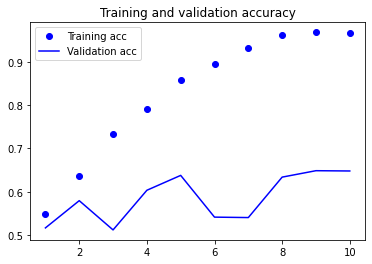

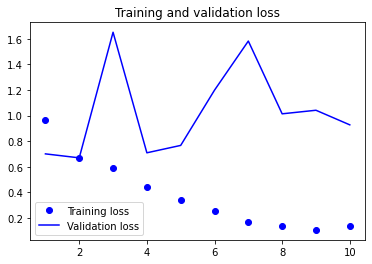

In [13]:
show_history(MLP_history)

In [15]:
resDF=pd.DataFrame(MLP_history.history)
print(resDF[['acc','val_acc','loss','val_loss']])

      acc   val_acc      loss  val_loss
0  0.5475  0.516500  0.964372  0.700670
1  0.6355  0.579333  0.669566  0.669616
2  0.7335  0.511833  0.587611  1.650873
3  0.7915  0.603333  0.440305  0.709041
4  0.8580  0.637667  0.342125  0.766799
5  0.8955  0.541333  0.255326  1.198369
6  0.9305  0.540333  0.171219  1.582050
7  0.9605  0.633667  0.139088  1.013586
8  0.9680  0.648500  0.106599  1.041433
9  0.9665  0.647833  0.139635  0.927427


classic overfitting, to such a degree you wonder whether it's even doing something productive on the validation samples. Let's try an LSTM model

# LSTM model

In [16]:
clear_session()
modelLSTM=Sequential(name = 'LSTM')
modelLSTM.add(layers.Embedding(maxWords,Glove_emDim,input_length=maxLen))
modelLSTM.add(layers.LSTM(64,dropout=0.20, recurrent_dropout=0.20,
                    recurrent_activation='sigmoid'))
modelLSTM.add(layers.Dense(1,activation='sigmoid'))
modelLSTM.layers[0].set_weights([emMat])
modelLSTM.layers[0].trainable=False
modelLSTM.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 80, 100)           1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,042,305
Trainable params: 42,305
Non-trainable params: 1,000,000
_________________________________________________________________


In [17]:
# Compile
modelLSTM.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['acc'],
)

In [18]:
# train
LSTM_history=modelLSTM.fit(XTrain, yTrain,
        epochs=20,
        batch_size=32,
        validation_data=(XVal,yVal),
        verbose=0,
        callbacks=[])
model.save_weights('assign-4-LSTM1-pretrained-test-1.h5')

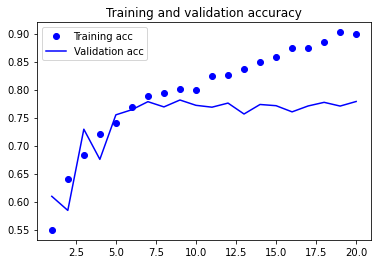

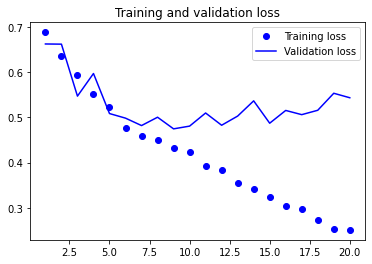

In [19]:
show_history(LSTM_history)

This works, but obviously we're seeing overfitting in later epochs. We might consider early stopping (As in part 1) and weight regularization. I think there's also a case to be made for a more complex model, or possibly feeding more data into the dense layer.

In [20]:
clear_session()

from tensorflow.keras.constraints import max_norm
# max_norm implements max_norm weight based regularization
# caps the sum of weights for each layer and redistributes
kernal_constraint = max_norm(2.)

LSTM2=Sequential(name = 'LSTM2')
LSTM2.add(layers.Embedding(maxWords,Glove_emDim,input_length=maxLen))
LSTM2.add(layers.Bidirectional( # add bidirectional since we can see the whole sentence
    layers.LSTM(128, # more neurons
    dropout=0.50, recurrent_dropout=0.50, recurrent_activation='sigmoid', # raised dropout
    return_sequences=True,# added return_sequences so Dense explicitly sees all the word encodings
    kernel_constraint=kernal_constraint))) # added weight regularization
LSTM2.add(layers.Bidirectional(layers.LSTM(128, dropout=0.50, recurrent_dropout=0.50, 
    recurrent_activation='sigmoid', return_sequences=True,# going to dense
    kernel_constraint=kernal_constraint)))
LSTM2.add(layers.Dense(1, activation='sigmoid', kernel_constraint=kernal_constraint))
LSTM2.layers[0].set_weights([emMat])
LSTM2.layers[0].trainable=False
LSTM2.summary()

Model: "LSTM2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 80, 100)           1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 80, 256)           234496    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 80, 256)           394240    
_________________________________________________________________
dense (Dense)                (None, 80, 1)             257       
Total params: 1,628,993
Trainable params: 628,993
Non-trainable params: 1,000,000
_________________________________________________________________


In [21]:
# early stopping
from tensorflow.keras.callbacks import EarlyStopping
callback=EarlyStopping(monitor='val_loss',patience=5)

# Compile
LSTM2.compile(
    optimizer=keras.optimizers.Adam(lr = 1e-4),
    loss='binary_crossentropy',
    metrics=['acc'],
)

In [22]:
# train
LSTM2_history=LSTM2.fit(XTrain, yTrain,
        epochs=30,
        batch_size=32,
        validation_data=(XVal,yVal),
        verbose=0,
        callbacks=[callback])
LSTM2.save_weights('assign-4-LSTM2-pretrained.h5')

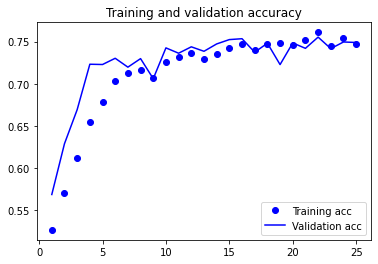

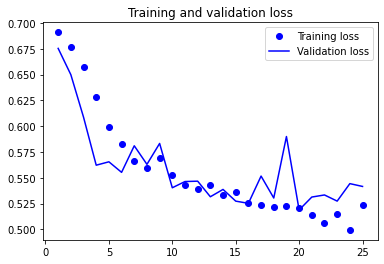

In [23]:
show_history(LSTM2_history)

In [24]:
LSTM2.evaluate(XTest,yTest)

188/188 [==============================] - 6s 34ms/step - loss: 0.5604 - acc: 0.7391


[0.5603619813919067, 0.739050030708313]

# [juliachildvoice] Here's some embeddings I prepared earlier [/jcv]
What if we didn't have access to the Glove word embeddings? Or the review is written in Klingon?
We can generate our own embeddings based on the training set and then use it to predict sentiment.
<p>
I tried a version of the autoencoder using the Glove embeddings and guess what - the loss at the end was the same. Therefore, I predict that we'll get equivalent, if middling accuracies.

In [25]:
XTrainEm = db4['XTrainEm']
XValEm = db4['XValEm']
XTestEm = db4['XTestEm']
yTrain=db4['yTrain'] # we did not embed the prediction targets
yVal=db4['yVal']
yTest=db4['yTest']

JCV_emDim = 128 # what I used for part 1

In [26]:
clear_session()
modelJCV=Sequential(name = 'JCV')
modelJCV.add(layers.Input(shape = [JCV_emDim])) # embeddings, number of words
modelJCV.add(layers.Dense(128, activation='relu', kernel_constraint=kernal_constraint))
modelJCV.add(layers.Dense(32, activation='relu', kernel_constraint=kernal_constraint))
modelJCV.add(layers.Dense(1, activation='sigmoid', kernel_constraint=kernal_constraint))
# rather than setting weights and freezing the layer, we are using the output.
# copying the encoder and encoder weights is more keratic (tf version of 'pythonic')
# but I'm not teribly keratic myself. Probably a good thing, since keratic = horn-like

modelJCV.summary()

Model: "JCV"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 20,673
Trainable params: 20,673
Non-trainable params: 0
_________________________________________________________________


In [27]:
# early stopping
from tensorflow.keras.callbacks import EarlyStopping
callback=EarlyStopping(monitor='val_loss',patience=5)

# Compile
modelJCV.compile(
    optimizer=keras.optimizers.Adam(lr = 1e-4),
    loss='binary_crossentropy',
    metrics=['acc'],
)

In [28]:
# train
JCV_history=modelJCV.fit(XTrainEm, yTrain,
        epochs=30,
        batch_size=32,
        validation_data=(XValEm,yVal),
        verbose=0,
        callbacks=[callback])
modelJCV.save_weights('assign-4-JCV.h5')

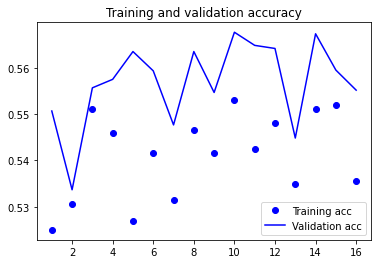

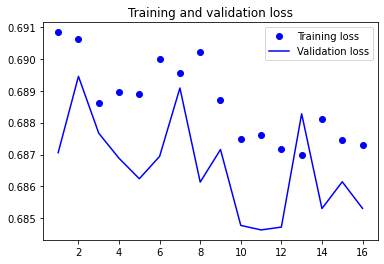

In [29]:
show_history(JCV_history)

This is pathetic. Barely better than chance. Also surprising given that the autoencoder showed a similar loss to to the glove-based autoencoder.
<p>
Few options:
    1. The embedding is screwed up and I need to generate in real time
    2. The autoencoder is poorly optimized for the task
    3. The autoencoder is not as good as training an encoder on 6 billion words
I will resolve this by:
    1. Rerunning with pretrained encoder, frozen weights
    2. Rerunning with pretrained encoder, non-frozen weights
    3. Giving up

In [30]:
# reload preterined encoder and freeze
# words -> frozen encodeM -> Classifier should equal embeddings -> Classifier
clear_session()
encode_emDim = 64
inputPadded=layers.Input(shape=(maxLen,)) # input layer, 80 words
embedLayer=layers.Embedding(maxWords, output_dim=encode_emDim, input_length=maxLen)
x = embedLayer(inputPadded)
state_hidden=layers.Bidirectional(layers.LSTM(64,activation='selu'))(x)
encodeMF=Model(inputs=inputPadded,outputs=state_hidden, name = 'encoder_frozen') # declare a model
encodeMF.load_weights('assign-4-encoder.h5')
encoderOut=encodeMF(inputPadded) # this hidden output is the product of the model

for layer in encodeMF.layers:
    layer.trainable = False

eDense1 =layers.Dense(128, activation = 'relu', kernel_constraint=kernal_constraint)
densed1 = eDense1(encoderOut)
drop1 = layers.Dropout(0.5)
ddensed1 = drop1(densed1)
eDense2 = layers.Dense(32, activation = 'relu', kernel_constraint=kernal_constraint)
densed2 = eDense2(ddensed1)
drop2 = layers.Dropout(0.5)
ddensed2 = drop2(densed2)
eDense3 = layers.Dense(1, activation = 'sigmoid')
eClass = eDense3(ddensed2)

encoder_class_model_frozen = Model(inputPadded, eClass, name = 'EncoderClassifier_Frozen')
encoder_class_model_frozen.summary()


Model: "EncoderClassifier_Frozen"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
encoder_frozen (Model)       (None, 128)               706048    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)    

In [31]:
# Compile
encoder_class_model_frozen.compile(
    optimizer=keras.optimizers.Adam(lr = 1e-4),
    loss='binary_crossentropy',
    metrics=['acc'],
)

In [32]:
ECMF_history=encoder_class_model_frozen.fit(XTrain, yTrain,
        epochs=30,
        batch_size=32,
        validation_data=(XVal,yVal),
        verbose=0,
        callbacks=[callback])

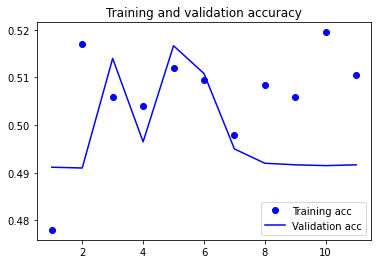

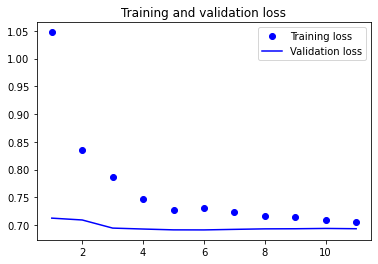

In [33]:
show_history(ECMF_history)

also crummy, but somehow not the same as the pre-embedded words, despite all my efforts to pre-set the randomizer
now let's see what happens when we allow the embedder to be trained

In [44]:
clear_session()
encode_emDim = 64
inputPadded=layers.Input(shape=(maxLen,)) # input layer, 80 words
embedLayer=layers.Embedding(maxWords, output_dim=encode_emDim, input_length=maxLen)
x = embedLayer(inputPadded)
state_hidden=layers.Bidirectional(layers.LSTM(64,activation='selu'))(x)
encodeMT=Model(inputs=inputPadded,outputs=state_hidden, name = 'encoder') # declare a model
encodeMT.load_weights('assign-4-encoder.h5') # refresh
encoderOut=encodeMT(inputPadded) # this hidden output is the product of the model
kernal_constraint = max_norm(1.)

for layer in encodeMT.layers:
    layer.trainable = True # just in case it got messed up

eDense1 =layers.Dense(128, activation = 'relu', kernel_constraint=kernal_constraint)
densed1 = eDense1(encoderOut)
drop1 = layers.Dropout(0.5)
ddensed1 = drop1(densed1)
eDense2 = layers.Dense(32, activation = 'relu', kernel_constraint=kernal_constraint)
densed2 = eDense2(ddensed1)
drop2 = layers.Dropout(0.5)
ddensed2 = drop2(densed2)
eDense3 = layers.Dense(1, activation = 'sigmoid')
eClass = eDense3(ddensed2)
    
encoder_class_model_trainable = Model(inputPadded, eClass, name = 'EncoderClassifier_Trainable')
encoder_class_model_trainable.summary()

Model: "EncoderClassifier_Trainable"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
encoder (Model)              (None, 128)               706048    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1) 

In [45]:
# Compile
encoder_class_model_trainable.compile(
    optimizer=keras.optimizers.Adam(lr = 1e-4),
    loss='binary_crossentropy',
    metrics=['acc'],
)

In [46]:
ECMT_history=encoder_class_model_trainable.fit(XTrain, yTrain,
        epochs=30,
        batch_size=32,
        validation_data=(XVal,yVal),
        verbose=0,
        callbacks=[callback])

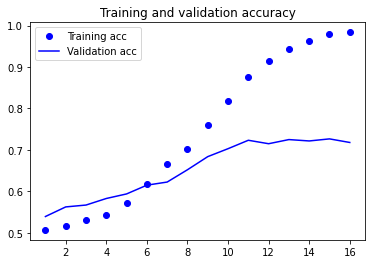

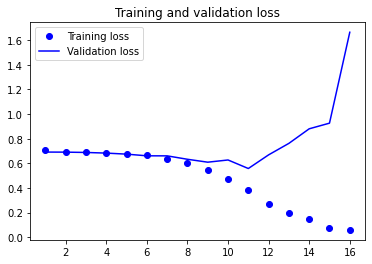

In [47]:
show_history(ECMT_history)

This is better but over-fitting. In a non-exercise environment, I would do more work on regularization, or move more data over to the training set. Versus Glove, this is a much more from scratch situation.
It seems that #2 from above is somewhat true - the encoder is not optimized for classification. However, it is also true that 2000 reviews are not a substitute for a 6 billion word corpus. I would feel sorry for the Glove people if it were.

In [48]:
encoder_class_model_trainable.evaluate(XTest,yTest)

188/188 [==============================] - 2s 11ms/step - loss: 1.7663 - acc: 0.7110


[1.7662839889526367, 0.7110000252723694]

In [67]:
l = q>0
l

<tf.Tensor: shape=(3, 5, 5), dtype=bool, numpy=
array([[[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]]])>